# Linear Classifier - Softmax

In [1]:
# All necessary imports at the beginning
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata       
from sklearn.preprocessing import OneHotEncoder

## Load, explore and prepare dataset

The MNIST dataset is a classic Machine Learning dataset you can get it and more information about it from the website of [Yann Lecun](http://yann.lecun.com/exdb/mnist/). MNIST contains handwrittin digits and is split into a tranings set of 60000 examples and a test set of 10000 examples. You can use the module ```sklearn``` to load the MNIST dataset in a convenient way. 
easy load, mldata.org, orginal mnist, mnist link and description

In [2]:
mnist = fetch_mldata('MNIST original') #load MNIST
X, y = mnist["data"], mnist["target"] #separate images and labels

# shape of MNIST data
print('digits', X.shape)
print('labels',y.shape)

('digits', (70000, 784))
('labels', (70000,))


To get a visualization of MNIST we will plot a digit. Each line represents an image in flatten form (all pixel in a row). We have change the shape from a vector back to a matrix of the original shape to plot the image. In the case of MNIST this means a conversion of 784 pixel into 28x28 pixel. In addition we will check the label of that digit to verify it correspond to the image.

('label:', 8.0)


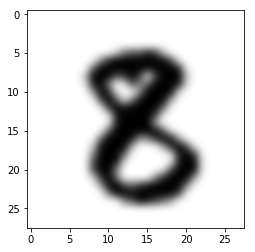

In [3]:
def plot_mnist_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap='binary', interpolation='bicubic')

#choose a random number, plot it and check label 
random_number = np.random.randint(1,60001)
print('label:',y[random_number]) 
plot_mnist_digit(X[random_number])

After a glimpse into MNIST let us explore it a bit further. Write a function ``` plot_mnist_digits(data, examples_each_row)``` that plots configurable number of examples for each class, like:
![MNIST Examples](images/MNIST_matrix.png)

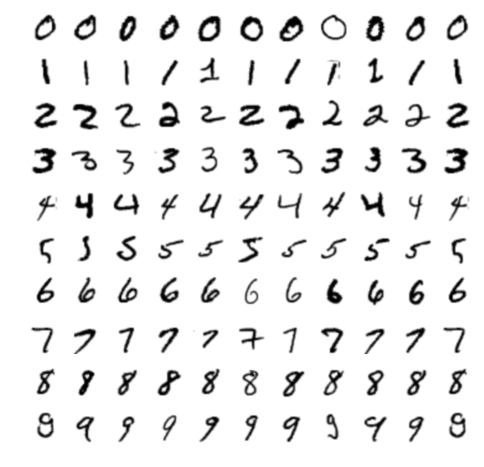

In [4]:
def plot_mnist_digits(data, examples_each_row):
    ############################################
    #TODO: Write a function that plots as many #    
    #      examples of each class as defiend   #
    #      by 'examples_each_row'              #
    ############################################
    fig = plt.figure(figsize=(8, 8))
    
    # Startindices of classes
    c, indices = np.unique(y, return_index=True)
    rows = len(c)  # rows = num of classes
    
    for i in range(1, rows * examples_each_row + 1):
        fig.add_subplot(rows, examples_each_row, i)
        plt.axis('off')
        cur_c = (i-1) / examples_each_row # current class
        # get start index of class and add column index
        dataindex = indices[cur_c] + (i-1)%rows
        # plot image
        plot_mnist_digit(data[dataindex])
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    
plot_mnist_digits(X, examples_each_row=11)
plt.show() 

After exploring MNIST let us prepare the date for our linear classifier. First we need to separate traning and test data. Further we will shuffle the traning data to get a random distribution.  

In [5]:
# split data into training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffle training data
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Define a linear classifier using Softmax

We will train a model to classify the MNIST dataset with the following equation:

$$ L = \frac{1}{M} \sum_{i=1}^{M} -log\; \left ( \frac{e^{h(x_j,\Theta)}}{\sum_{k=1}^{K}e^{h(x_k,\Theta)}} \right)_i + \frac{\lambda}{2} \sum_{}^{} \Theta^2, \: with \;\; h(X,\Theta) = X * \Theta $$

Using the universal equation for a loss function we can see the separate parts of that hugh equation.  

$$ L = \frac{1}{N} \sum_i L_i(h(x_i,\Theta),y_i) + \lambda R(\Theta)$$

We will implement each part on its own and put them together. That way it is much easier to understand whats going on. Let us start with the score function or hypothesis:

$$h(X,\Theta) = X * \Theta$$

It is possible to calculate all score values with one matrix multiplication ([dot product](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.dot.html)) so we can use the whole traning data $X$ instead of one digit $x_i$.

In [6]:
def class_scores(X,theta):
    ############################################
    #TODO: Implement the hypothesis and return #
    #      the score values for each class of  #
    #      every digit.                        #
    ############################################
    return np.dot(X, theta)
    ############################################
    #             END OF YOUR CODE             #
    ############################################


After we can define the data loss funtion $L_i$. We assume the score values are unnormalized log probabilities and we use the softmax function to calculate probabilities.
$$ P(Y=j\mid X=x_i) = \frac{e^{s_j}}{\sum_{k=1}^{K}e^{s_k}} $$
$$ L_i = -log\;P(Y=j\mid X=x_i) $$

Hint: If the correct classes (labels) are in a [one hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) shape you can use a matrix multiplication to extract the correct class. 

In [7]:
# Support function to convert label vector into a one hot encoding matrix
def onehot_encode_label(label):
    onehot_encoder = OneHotEncoder(sparse=False)
    label = label.reshape(len(label), 1)
    onehot_encoded_label = onehot_encoder.fit_transform(label)
    return onehot_encoded_label

# Calculate class probability distribution for each digit from given class scores
def softmax(class_scores):
    ############################################
    #TODO: Use the softmax function to compute #
    #      class probabilties                  #
    ############################################
    exp_scores = np.exp(class_scores)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    #shiftx = class_scores - np.max(class_scores)
    #exps = np.exp(shiftx)
    #return exps / np.sum(exps)
    
    ############################################
    #             END OF YOUR CODE             #
    ############################################

# Compute data_loss L_i for the correct class
def data_loss(class_probabilities, onehot_encode_label):
    ############################################
    #TODO: With hot encoded labels and class   #
    #      probabilties calculate data loss    #
    #      L_i                                 #
    ############################################
    #print("probs", class_probabilities)
    #print("labels", onehot_encode_label)
    
    return -1.0*(np.log(class_probabilities)*onehot_encode_label)
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    

Now we will calculate loss $L$ using the defined functions. 

$$ L = \frac{1}{M} \sum_i L_i(h(x_i,\Theta),y_i) + \lambda R(\Theta)$$

Besides the loss L we will have to calculate the gradient for our loss function $L$. To minimize our loss we will need the gradient. For more information about the gradient you can use additional sources, like that good [blog post](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/).

In [8]:
def lossFun(X, y, theta, lam):
    encoded_labels = onehot_encode_label(y)           # also needed for the gradient, therefore separated calculated
    probabilities = softmax(class_scores(X,theta))    # also needed for the gradient, therefore separated calculated
    loss_Li = data_loss(probabilities,encoded_labels) 
    
    m = X.shape[0]  # number of training data for normalization
    #print("number examples", m)
    #print("loss li", loss_Li)
    l2_regularization = (lam/2)*np.sum(theta*theta)   # regularization loss

    ############################################
    #TODO: Put everthing together and calculte #
    #      loss L and gradient dL with given   #
    #      variables.                          #
    ############################################
    loss = np.sum(loss_Li)/m + l2_regularization

    dscores = probabilities
    dscores -= encoded_labels
    dscores /= m
    
    gradient = np.dot(X.T, dscores) + (l2_regularization * theta)
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    
    return loss,gradient

## Reduce the cost using gradient descent

In [9]:
def gradient_descent(training_data, training_label, theta, lam=0.5, iterations=10, learning_rate=1e-5):
    losses = []
    ############################################
    #TODO: Optimize loss with gradient descent #
    #      update rule. Return a final model   #
    #      and a history of loss values.       #
    ############################################
    for i in tqdm(range(iterations), ascii=False, desc="gradient descent bitches"):
        (lossReturn, gradient) = lossFun(training_data, training_label, theta, lam)
        #if i % 10 == 0 and i != 0:
            #print "iteration %d: loss %f" % (i, lossReturn)
        losses.append(lossReturn)
        theta += -learning_rate * gradient
    ############################################
    #             END OF YOUR CODE             #
    ############################################    
    return theta, losses

# Initialize learnable parameters theta 
theta = np.zeros([X_train.shape[1],len(np.unique(y_train))])
# Start optimization with traning data, theta and optional hyperparameters
opt_model, loss_history = gradient_descent(X_train,y_train,theta,iterations=250)

gradient descent bitches: 100%|██████████| 250/250 [03:30<00:00,  1.19it/s]


## Evaluate model
Let us look at the optimization results. Final loss tells us how far we could reduce costs during traning process. Further we can use the first loss value as a sanity check and validate our implementation of the loss function works as intended. Recall loss value after first iteration should be $ log\:c$ with $c$ being number of classes. To visulize the whole tranings process we can plot losss values from each iteration as a loss curve. 

('last iteration loss:', 0.32865812263228605)
('first iteration loss:', 2.3025850929940446)
training accuracy: 0.91
test accuracy: 0.91


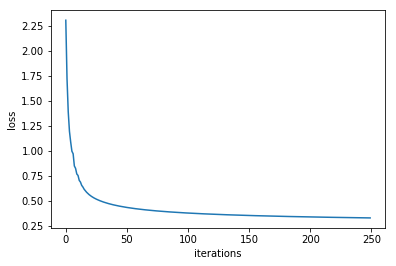

In [21]:
# check loss after last iteration
print('last iteration loss:',loss_history[-1])
# Sanity check: first loss should be ln(10)
print('first iteration loss:',loss_history[0])
# Plot a loss curve
plt.plot(loss_history)
plt.ylabel('loss')
plt.xlabel('iterations')

scores = np.dot(X_train, opt_model)
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y_train))

scores = np.dot(X_test, opt_model)
predicted_class = np.argmax(scores, axis=1)
print 'test accuracy: %.2f' % (np.mean(predicted_class == y_test))

Evaluation above gave us some inside about the optimization process but did not quantified our final model. One possibility is to calculate model accuracy.

In [38]:
def modelAccuracy(X,y,theta):
    # calculate probabilities for each digit
    probabilities = softmax(np.dot(X,theta))
    # class with highest probability will be predicted
    prediction = np.argmax(probabilities,axis=1)
    # Sum all correct predictions and divied by number of data
    #### HAD TO FIX THIS FLOATING POINT OPERATION ####
    accuracy = (sum(prediction == y))/(X.shape[0]*1.0)
    ##################################################
    return accuracy

print('Training accuracy: ', modelAccuracy(X_train,y_train,opt_model))
print('Test accuracy: ', modelAccuracy(X_test,y_test,opt_model))

('Training accuracy: ', 0.9093833333333333)
('Test accuracy: ', 0.9131)


But that quantification is limited. A more gerenell approach is to calculate a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and get different model measurements from it. A good overview for model measurements is provided by the wikipedia article of [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). We implement a confusion matrix for our model and calculate a [F1 score](https://en.wikipedia.org/wiki/F1_score) and ```print()``` it.

In [12]:
def confusionMatrix(X,y,theta):
    ############################################
    #TODO: Calculate a confusion matrix for    # 
    #      and it.                             #
    ############################################
    return None
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    
def f1Score(confMatrix):
    ############################################
    #TODO: Calculate a F1 score from a given   #
    #      confusion matrix.                   #
    ############################################
    return None
    ############################################
    #             END OF YOUR CODE             #
    ############################################ 

Interesting is to plot a part of $theta$, because you can visualize the learned templates for each class.

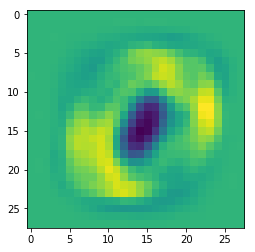

In [13]:
plt.imshow(np.reshape(opt_model[:,0],[28,28]))